In [80]:
import random
import numpy as np
from statistics import mean
from random import randrange
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
import sys
from scipy.spatial import distance
from operator import itemgetter
import gc
%matplotlib inline

In [81]:
train = np.genfromtxt(
        'datasets/MNIST_train.csv', delimiter=',')

In [82]:
X_train, y_train = train[:,1:], train[:,0]

In [83]:
from scipy.stats import norm
import math
from sklearn import preprocessing
def get_nth_quartile(data, n):  
    if n < 1 or n > 3:
        return false
    data.sort()
    position = 1 + (len(data)-1)*n/4
    pos_integer = int(math.modf(position)[1])
    pos_decimal = position - pos_integer
    quartile = data[pos_integer - 1] + (data[pos_integer] - data[pos_integer - 1])*pos_decimal
    return quartile

def min_max_scaling(data):
    return np.where(data.ptp(0) == 0, data, (data - data.min(0)) / data.ptp(0))

def standard_scaling(data):
    return preprocessing.normalize(data)

def max_abs_scaling(data):
    return np.where(abs(data.max(0)) == 0, data, data / abs(data.max(0)))

def robust_scaling(data):
#     return RobustScaler().fit(data).transform(data)
    temp=data.copy()
    tmp = data.copy()
    for i in range(len(tmp)):
        quartile=get_nth_quartile(tmp[i],1)
        quartiletre=get_nth_quartile(tmp[i],3)
        median=get_nth_quartile(tmp[i],2)
        if quartiletre-quartile != 0:
            temp[i]=[((temp[i][j] - median) / (quartiletre-quartile)) for j in range(len(temp[i]))]
    return temp

def unit_scaling(data):
    temp=np.ndarray(data.shape)
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] != 0:
                temp[i][j]=1
    return temp


In [84]:
X_train_nr = standard_scaling(X_train)

In [90]:
def leave_one_out(X, y, p):
    n_samples = y.shape[0]
    indices = np.arange(n_samples)
    
    batch_numbers = 200
    batch_validation_idx = np.array_split(indices, batch_numbers)
    
    # cumulated_loss for k in range [1,20]
    cumulated_loss = [0 for i in range(20)]
    accuracy = [0 for i in range(20)]
    
    for u in range(batch_numbers):
        print(f"start {u} batch")
        validation_idx = batch_validation_idx[u]
        pdist = distance.cdist(X[validation_idx], X,'minkowski',2) 
        y_indices = np.argsort(pdist) #shape: batch_size(3000)*sample_numbers(60,000)
        del pdist
        gc.collect()
        
        for k in range(20):
            k_closests = y[y_indices[:,1:k+2]] #shape: batch_size*k

            # random selection with bincount
            # input: k_closest with shape (batch_size,k)
            # output: y_pred with shape (batch_size,)

            # shape: (batch_size,10)
            bincount = np.array([np.count_nonzero(k_closests == j, axis = 1) for j in range(10)]).transpose()

            max_bin_values = np.amax(bincount,axis=1)
            a = np.array([bincount[j] == max_bin_values[j] for j in range(max_bin_values.shape[0])])
            y_pred = np.array([])
            for row in a:
                tmp = np.asarray(np.nonzero(row)).reshape(-1)
                y_pred = np.append(y_pred,np.random.choice(tmp,1,replace=False))

            cumulated_loss[k] += np.sum(y_pred == y[validation_idx])
    
    for k in range(20):
        accuracy[k] = cumulated_loss[k] / n_samples
    
    return accuracy

In [91]:
results = leave_one_out(X_train_nr,y_train,2)

start 0 batch


KeyboardInterrupt: 

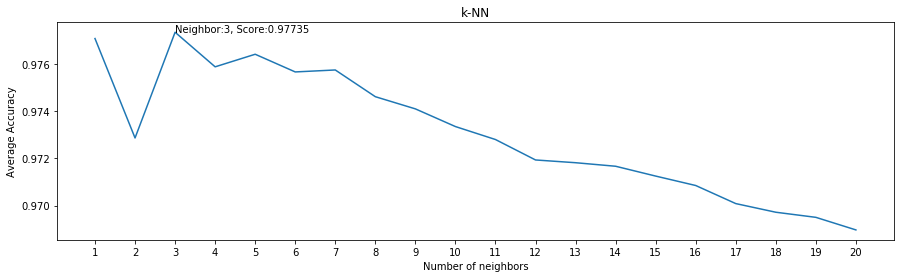

In [89]:
k_neighbors = np.linspace(1,20,20)
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xticks(k_neighbors)
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
plt.plot(k_neighbors,results)
plt.text(results.index(max(results))+1, max(results), f'Neighbor:{results.index(max(results))+1}, Score:{max(results)}')
plt.show()

In [18]:
def helper_4(train_X, train_y, cv=5):
    fold_size, batch_numbers = int(train_y.shape[0]/cv), 20
    indices = np.arange(train_y.shape[0])
    np.random.RandomState(123).shuffle(indices)
    results = [[] for k in range(20)]
    for i in range(cv):
        validation_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.concatenate((indices[:i*fold_size], indices[(i+1)*fold_size:]))
        batch_train_idx = np.array_split(train_idx, batch_numbers)
        batch_validation_idx = np.array_split(validation_idx, batch_numbers)
        validation_y_pred = [[] for k in range(20)]
        
        print("start:",i,"cross validation")
        for u in range(batch_numbers):
            print("start:",u,"validation batch")
            validation_unit_batch_idx = batch_validation_idx[u]
            level = [[[] for i in range(validation_unit_batch_idx.shape[0])] for k in range(20)]
            for j in range(batch_numbers):
                train_unit_batch_idx = batch_train_idx[j]
                distances=distance.cdist(train_X[validation_unit_batch_idx], train_X[train_unit_batch_idx],'minkowski',2)
                #validation_y_indices size:(validation_batch_size*train_batch_size)
                _indices = np.argsort(distances)[:,:20]
                for k in range(20):
                    k_indices = _indices[:,:k+1]
                    k_distances = np.array([distances[i,indices] for i, indices in zip(range(k_indices.shape[0]),k_indices)])
                    validation_y_indices = np.array([train_unit_batch_idx[indices] for indices in k_indices])
                    k_labels = np.array([train_y[indices] for indices in validation_y_indices]).astype(int)
                    #k distances size:(validation_batch_size*k)
                    #k labels size:(validation_batch_size*k)                
                    # level element tuple size(k,k)
                    for i in range(validation_unit_batch_idx.shape[0]):
                        level[k][i].extend(list(zip(k_distances[i],k_labels[i])))
                        
                 
            for i in range(validation_unit_batch_idx.shape[0]):
                for k in range(20):
                    level[k][i].sort(key=itemgetter(0))
                    k_closests = np.array([x[1] for x in level[k][i][:k+1]])
                    bincount = np.array([np.count_nonzero(k_closests == j) for j in range(10)]).transpose()
                    max_bin_values = np.amax(bincount)
                    a = np.array([bincount == max_bin_values])
                    
                    for row in a:
                        tmp = np.asarray(np.nonzero(row)).reshape(-1)
                        validation_y_pred[k] = np.append(validation_y_pred[k],np.random.choice(tmp,1,replace=False))   
                        
        for k in range(20):
            validation_acc = np.sum(validation_y_pred[k] == train_y[validation_idx])
            results[k].append(validation_acc/validation_idx.shape[0])
    return results

In [19]:
acc = helper_4(X_train_nr, y_train, cv=10)
for result in acc:
    print(sum(result)/10)

start: 0 cross validation
start: 0 validation batch
start: 1 validation batch
start: 2 validation batch
start: 3 validation batch
start: 4 validation batch
start: 5 validation batch
start: 6 validation batch
start: 7 validation batch
start: 8 validation batch
start: 9 validation batch
start: 10 validation batch
start: 11 validation batch
start: 12 validation batch
start: 13 validation batch
start: 14 validation batch
start: 15 validation batch
start: 16 validation batch
start: 17 validation batch
start: 18 validation batch
start: 19 validation batch
start: 1 cross validation
start: 0 validation batch
start: 1 validation batch
start: 2 validation batch
start: 3 validation batch
start: 4 validation batch
start: 5 validation batch
start: 6 validation batch
start: 7 validation batch
start: 8 validation batch
start: 9 validation batch
start: 10 validation batch
start: 11 validation batch
start: 12 validation batch
start: 13 validation batch
start: 14 validation batch
start: 15 validation ba

In [20]:
results = []
for result in acc:
    results.append(sum(result)/10)

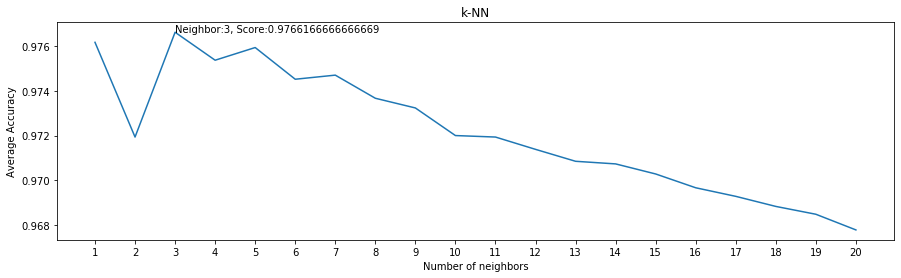

In [21]:
k_neighbors = np.linspace(1,20,20)
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xticks(k_neighbors)
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
plt.plot(k_neighbors,results)
plt.text(results.index(max(results))+1, max(results), f'Neighbor:{results.index(max(results))+1}, Score:{max(results)}')
plt.show()

In [ ]:
x = np.array([])